### Playing around with the parameter C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
%matplotlib inline

#### Creation of data
We create 2 times 100 data points as follows:

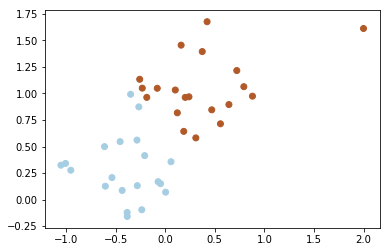

In [2]:
def get_random_data(outlyer_pos=2):
    np.random.seed(42)
    y = np.concatenate((np.repeat(-1,20),np.repeat(1,20))) 
    X = np.random.rand(40,2) 
    X[:,0] += 0.54*y
    X[0,0] = 0.45
    c, s = np.cos(-0.78), np.sin(-0.78)
    U = np.matrix([[c, -s], [s, c]])
    X_rot = np.matmul(X,U)
    X_rot[25,0] = outlyer_pos
    return X_rot,y

X,y = get_random_data()
np.shape(y)
plt.scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired)
plt.show()

#### The meaning of the parameter C

To get an idea about the meaning of the parameter C we look at the number of support vectors. The support vectors either lie on the wrong side or in the margin. So many support vectors indicate a large margin.

In [3]:
for C in (1e-3, 1e-2, 1e-1, 1, 1e1,1e2,1e10):
    svc = svm.SVC(kernel='linear', C=C).fit(X,y)
    print('C={0} number of SV={1}'.format(C, len(svc.support_vectors_)))

C=0.001 number of SV=40
C=0.01 number of SV=40
C=0.1 number of SV=32
C=1 number of SV=14
C=10.0 number of SV=7
C=100.0 number of SV=4
C=10000000000.0 number of SV=3


The larger the value C is the less SV. Hence with a rising C the margin gets smaller. This is consistent with  Elements of statistical learning and the slides. 

```
The margin is larger for C = 0.01 than it is for C = 10, 000. p421
```

Further the dual form in http://scikit-learn.org/stable/modules/svm.html#svc and Eq. 12.13 in Elements of statistical learning look the same.

### Introducation to statistical learning
The parameter C in the ISLR is different. They always try to maximize the margin M under the constrain $\sum \beta^2 = 1$ and do not set the margin width to 1 and then minimize $\beta$.

In the R example they also talk about a parameter `cost` which is same as the C above.


## Animation

In [4]:
# Plots the data and predictions
# Code taken from: http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py
def plot_preds(clf, X, y):
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    ## plotting the prediction 
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.clf()
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)    
    
    w = clf.coef_[0]
    a = -w[0] / w[1]
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    x_m = np.linspace(-5, 5)
    y_m = a * x_m - (clf.intercept_[0]) / w[1]
    yy_down = y_m + a * margin
    yy_up = y_m - a * margin

    plt.plot(x_m, y_m, 'k-')
    plt.plot(x_m, yy_down, 'k--')
    plt.plot(x_m, yy_up, 'k--')
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.title("Num SV {}".format(len(clf.support_vectors_)))

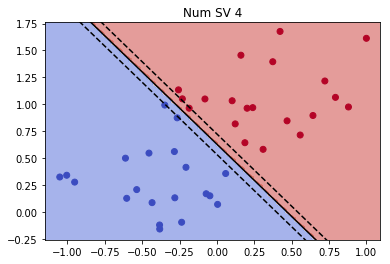

In [5]:
from ipywidgets import *

def plot_func(C):
    X,y = get_random_data(1)
    clf = svm.SVC(kernel='linear', C=C)
    clf.fit(X=X, y=y)
    plot_preds(clf, X, y)

interact(plot_func, 
         C=(0.1,150,0.5)
         #out=FloatSlider(value=1, min=-3, max=3, step=0.5)
        )